# 手撸YOLOv3

## 主要参考代码

https://github.com/williamcfrancis/YOLOv3-Object-Detection-from-Scratch/blob/main/YOLO_object_detection.ipynb

https://github.com/westerndigitalcorporation/YOLOv3-in-PyTorch/blob/release/src/model.py

## 执行环境与关键python库

In [1]:
# !pip install pytorch_lightning torch==2.5.1 albumentations numpy==1.23.1 tensorboard

# # 首先卸载所有相关包
# !pip uninstall -y tensorboard tensorboard-plugin-wit tensorflow-tensorboard tensorflow torch-tb-profiler

# # 清理 pip 缓存
# !pip cache purge

# # 重新安装必要的包
# !pip install tensorboard==2.12.0
# !pip install tensorboard-plugin-wit==1.8.1

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision
import torch.nn as nn


import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from tqdm import tqdm


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 42
torch.manual_seed(seed)

/home/work/miniconda3/envs/yolo/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [3]:
# 中文字体显示
# https://blog.51cto.com/u_14020077/5836447

import matplotlib
print(matplotlib.matplotlib_fname())

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文

# 查看matplotlib字体
import matplotlib.font_manager as fm
print(fm.get_font_names())

/home/work/miniconda3/envs/yolo/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc
['DejaVu Serif Display', 'NanumGothicCoding', 'cmmi10', 'NanumSquareRound', 'STIXSizeFourSym', 'cmr10', 'cmtt10', 'Nanum Pen Script', 'DejaVu Sans', 'DejaVu Serif', 'STIXGeneral', 'STIXSizeOneSym', 'cmex10', 'cmb10', 'DejaVu Sans Mono', 'STIXSizeFiveSym', 'NanumSquare', 'NanumBarunpen', 'STIXSizeThreeSym', 'NanumMyeongjo', 'Nanum Brush Script', 'NanumGothic', 'cmsy10', 'DejaVu Sans Display', 'cmss10', 'STIXSizeTwoSym', 'STIXNonUnicode', 'NanumBarunGothic']


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision
import torch.nn as nn

import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

from tqdm import tqdm

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 42
torch.manual_seed(seed)

In [5]:
import torch
torch.__version__

'2.5.1'

## 数据集检查

### COCOYOLODataset
- 介绍
    - `COCOYOLODataset`主要作为简单的数据检查用，不用于训练
- 参数
    - img_dir: 图像目录
    - label_dir: 标签目录
    - img_size: 图像大小
    - augment: 是否进行数据增强
- 函数
    - __init__: 初始化数据集
    - __len__: 返回数据集长度
    - __getitem__: 获取数据集中的一个样本
- 返回
    - 数据集

> 后面的`COCODataset`和`create_dataloaders`， 配合`YOLOV3_Lightning`用于训练


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import glob

import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F  # 添加这个导入
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image


import pytorch_lightning as pl

import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def check_label_values(labels, verbose=True):
    """
    Check if label values are within valid ranges:
    - First value (class_id): should be an integer
    - Other values (x, y, w, h): should be float in range [0, 1]
    
    Args:
        labels: tensor or numpy array of shape (N, 5) containing [class_id, x, y, w, h]
        verbose: whether to print detailed error messages
    
    Returns:
        bool: True if all values are valid, False otherwise
        list: List of error messages if any
    """
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    if len(labels.shape) == 1:
        labels = labels.reshape(1, -1)
    
    errors = []
    is_valid = True
    
    for i, label in enumerate(labels):
        # Check class_id
        if not np.isclose(label[0], np.round(label[0])):
            is_valid = False
            msg = f"Row {i}: class_id {label[0]} is not an integer"
            errors.append(msg)
            if verbose:
                print(msg)
        
        # Check x, y, w, h are in [0, 1]
        for j, (name, value) in enumerate(zip(['x', 'y', 'w', 'h'], label[1:])):
            if value < 0 or value > 1:
                is_valid = False
                msg = f"Row {i}: {name} value {value} is outside range [0, 1]"
                errors.append(msg)
                if verbose:
                    print(msg)
    
    if is_valid and verbose:
        print("All label values are valid!")
        
    return is_valid, errors

def fix_label_values(labels, eps=1e-6):
    """
    Fix label values to ensure they are within valid ranges:
    - First value (class_id): round to nearest integer
    - Other values (x, y, w, h): clip to range [0, 1]
    
    Args:
        labels: tensor or numpy array of shape (N, 5) containing [class_id, x, y, w, h]
        eps: small value to ensure values don't exactly equal 0 or 1
    
    Returns:
        Fixed labels with same type as input
    """
    is_tensor = isinstance(labels, torch.Tensor)
    if is_tensor:
        labels = labels.cpu().numpy()
    
    if len(labels.shape) == 1:
        labels = labels.reshape(1, -1)
    
    fixed_labels = labels.copy()
    
    # Round class_id to nearest integer
    fixed_labels[:, 0] = np.round(fixed_labels[:, 0])
    
    # Clip x, y, w, h to [eps, 1-eps]
    fixed_labels[:, 1:] = np.clip(fixed_labels[:, 1:], eps, 1-eps)
    
    if is_tensor:
        fixed_labels = torch.from_numpy(fixed_labels)
        if labels.device.type == 'cuda':
            fixed_labels = fixed_labels.cuda()
    
    return fixed_labels



class COCOYOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=640, augment=True):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.augment = augment
        
        # 获取所有图片文件
        self.img_files = sorted(glob.glob(os.path.join(img_dir, "*.*")))
        # 获取对应的标签文件
        self.label_files = [
            os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
            for img_path in self.img_files
        ]
        
        # 添加图片名列表
        self.img_names = [os.path.basename(f) for f in self.img_files]
        
        # 基础变换
        self.transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        # 加载图像
        img_path = self.img_files[index]
        img = Image.open(img_path).convert('RGB')
        
        # 获取原始图像尺寸
        width = img.width
        height = img.height
        
        # 应用变换
        img = self.transforms(img)
        
        # 加载标签
        label_path = self.label_files[index]
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    # class_id, x_center, y_center, width, height
                    class_id = int(data[0])
                    x_center = float(data[1])
                    y_center = float(data[2])
                    w = float(data[3])
                    h = float(data[4])
                    
                    # YOLO格式已经是归一化的，所以不需要再归一化
                    labels.append([class_id, x_center, y_center, w, h])
        
        # 转换为tensor
        if len(labels) > 0:
            labels = torch.FloatTensor(labels)
        else:
            # 如果没有标签，创建一个空的标签tensor
            labels = torch.zeros((0, 5))
            
        # 获取图片名
        img_name = self.img_names[index]
        
        # 检查并修复标签值
        if len(labels) > 0:
            labels = torch.FloatTensor(labels)
            is_valid, errors = check_label_values(labels, verbose=False)
            if not is_valid:
                print(f"Invalid labels found in {self.img_files[index]}")
                for error in errors:
                    print(f"  {error}")
                labels = fix_label_values(labels)
        else:
            labels = torch.zeros((0, 5))
        
        return img, labels, img_name

def create_dataloader3(img_dir, label_dir, batch_size=16, img_size=640, augment=True, shuffle=True):
    """创建数据加载器"""
    dataset = COCOYOLODataset(
        img_dir=img_dir,
        label_dir=label_dir,
        img_size=img_size,
        augment=augment
    )
    
    # 修改collate函数以处理图片名
    def collate_fn3(batch):
        imgs, labels, img_names = zip(*batch)
        # 堆叠图像
        imgs = torch.stack(imgs)
        
        # 返回图像、标签列表和图片名
        return imgs, labels, img_names
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        collate_fn=collate_fn3
    )
    
    return loader


In [7]:
# 测试和修改数值范围

# Test case 1: Valid labels
valid_labels = np.array([
    [0, 0.5, 0.5, 0.2, 0.3],
    [1, 0.1, 0.7, 0.4, 0.2]
])
print("Test case 1 - Valid labels:")
is_valid, errors = check_label_values(valid_labels)

# Test case 2: Invalid labels
invalid_labels = np.array([
    [0.1, -0.1, 0.5, 1.2, 0.3],  # Non-integer class_id and invalid x,w
    [1, 0.1, 1.7, 0.4, 0.2]      # Invalid y
])
print("\nTest case 2 - Invalid labels:")
is_valid, errors = check_label_values(invalid_labels)

print("\nFixing invalid labels:")
fixed_labels = fix_label_values(invalid_labels)
print("Fixed labels:")
print(fixed_labels)
is_valid, errors = check_label_values(fixed_labels)

Test case 1 - Valid labels:
All label values are valid!

Test case 2 - Invalid labels:
Row 0: class_id 0.1 is not an integer
Row 0: x value -0.1 is outside range [0, 1]
Row 0: w value 1.2 is outside range [0, 1]
Row 1: y value 1.7 is outside range [0, 1]

Fixing invalid labels:
Fixed labels:
[[0.00000e+00 1.00000e-06 5.00000e-01 9.99999e-01 3.00000e-01]
 [1.00000e+00 1.00000e-01 9.99999e-01 4.00000e-01 2.00000e-01]]
All label values are valid!


In [8]:
# 数据路径
# train_img_dir = "../datasets/coco8/images/train"
# train_label_dir = "../datasets/coco8/labels/train"
train_img_dir = "../datasets/coco128/images"
train_label_dir = "../datasets/coco128/labels"
val_img_dir = "../datasets/coco8/images/val"
val_label_dir = "../datasets/coco8/labels/val"

# 创建数据加载器
train_loader = create_dataloader3(
    train_img_dir,
    train_label_dir,
    batch_size=4,
    img_size=640,
    augment=True
)

val_loader = create_dataloader3(
    val_img_dir,
    val_label_dir,
    batch_size=4,
    img_size=640,
    augment=False,
    shuffle=False
)

# 测试数据加载
for batch_i, (imgs, targets, img_names) in enumerate(train_loader):
    print(f"\nBatch {batch_i}:")
    print(f"Images shape: {imgs.shape}")
    print(f"Number of targets: {len(targets)}")

    for i, target in enumerate(targets):
        print(f"  Target {i} shape: {target.shape}")
            
    
    print("\nDetailed information:")
    for i, (target, img_name) in enumerate(zip(targets, img_names)):
        print(f"\nImage {i}:")
        print(f"  File name: {img_name}")
        print(f"  Target shape: {target.shape}")
        if len(target) > 0:
            print(f"  Number of objects: {len(target)}")
            print(f"  First object (class, x, y, w, h): {target[0].tolist()}")
    # break


Batch 0:
Images shape: torch.Size([4, 3, 640, 640])
Number of targets: 4
  Target 0 shape: torch.Size([3, 5])
  Target 1 shape: torch.Size([17, 5])
  Target 2 shape: torch.Size([5, 5])
  Target 3 shape: torch.Size([7, 5])

Detailed information:

Image 0:
  File name: 000000000154.jpg
  Target shape: torch.Size([3, 5])
  Number of objects: 3
  First object (class, x, y, w, h): [22.0, 0.4368149936199188, 0.746554970741272, 0.8175179958343506, 0.5068910121917725]

Image 1:
  File name: 000000000357.jpg
  Target shape: torch.Size([17, 5])
  Number of objects: 17
  First object (class, x, y, w, h): [34.0, 0.8454530239105225, 0.6193580031394958, 0.0062500000931322575, 0.12495400011539459]

Image 2:
  File name: 000000000192.jpg
  Target shape: torch.Size([5, 5])
  Number of objects: 5
  First object (class, x, y, w, h): [0.0, 0.6488749980926514, 0.7573019862174988, 0.2056249976158142, 0.4584369957447052]

Image 3:
  File name: 000000000138.jpg
  Target shape: torch.Size([7, 5])
  Number of 

In [9]:
targets

[tensor([[60.0000,  0.5000,  0.5024,  1.0000,  0.9951],
         [41.0000,  0.6301,  0.4403,  0.3514,  0.3649],
         [44.0000,  0.4531,  0.5262,  0.0921,  0.2042],
         [41.0000,  0.7517,  0.2112,  0.2225,  0.2966]]),
 tensor([[2.9000e+01, 7.3943e-01, 4.8450e-01, 2.9297e-02, 1.3125e-02],
         [0.0000e+00, 6.5723e-01, 5.7649e-01, 2.2723e-01, 3.8394e-01]]),
 tensor([[22.0000,  0.3462,  0.4933,  0.6894,  0.8921]]),
 tensor([[0.0000e+00, 4.5190e-01, 5.9701e-01, 5.8833e-01, 8.0598e-01],
         [6.5000e+01, 7.4395e-01, 5.8809e-01, 9.2688e-02, 2.9047e-02],
         [7.3000e+01, 5.5155e-01, 6.8315e-01, 2.1104e-02, 1.0970e-01],
         [7.3000e+01, 1.5408e-01, 2.7879e-01, 1.5042e-02, 2.4547e-02],
         [7.3000e+01, 7.6021e-02, 2.7925e-01, 1.9292e-02, 4.5125e-02],
         [7.3000e+01, 6.4958e-02, 2.7948e-01, 1.7500e-02, 4.5797e-02],
         [7.3000e+01, 1.0736e-01, 2.8077e-01, 5.9188e-02, 4.7187e-02],
         [7.3000e+01, 1.2510e-01, 1.9045e-01, 1.9637e-01, 7.1797e-02],
    

8,2,2,1 分别是image中的object框的数量

## dataset和dataloaders

### COCODataset
- 介绍函数功能
    - 创建COCO数据集
- 参数
    - img_dir: 图像目录
    - label_dir: 标签目录
    - img_size: 图像大小
    - augmentation_type: 数据增强类型
    - train: 是否为训练模式
- 函数
    - _get_albumentations_transforms: 使用albumentations进行数据增强
    - _get_torchvision_transforms: 使用torchvision进行数据增强
    - _get_transforms: 获取指定类型的数据增强
    - __len__: 返回数据集长度
    - __getitem__: 获取数据集中的一个样本
- 返回
    - 数据集

### create_dataloaders
- 函数功能
    - 创建训练和验证数据加载器
- 参数
    - train_img_dir: 训练图像目录
    - train_label_dir: 训练标签目录
    - val_img_dir: 验证图像目录
    - val_label_dir: 验证标签目录
    - img_size: 图像大小
    - batch_size: 批量大小
    - augmentation_type: 数据增强类型
    - num_workers: 工作线程数
- 返回
    - train_loader: 训练数据加载器
    - val_loader: 验证数据加载器



In [22]:
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F  # 添加这个导入
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
import numpy as np
import pytorch_lightning as pl


import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import warnings
import random

# 忽略特定的警告
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# 设置matplotlib中文字体
font_path = '../resource/SimHei.ttf'
if os.path.exists(font_path):
    # 添加字体文件
    fm.fontManager.addfont(font_path)
    # 设置默认字体
    plt.rcParams['font.family'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

class COCODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=512, augmentation_type='albumentations', train=True):
        """
        Args:
            img_dir: 图像目录路径
            label_dir: 标签目录路径
            img_size: 图像大小
            augmentation_type: 'albumentations' 或 'torchvision'
            train: 是否为训练模式
        """
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.train = train
        self.img_size = img_size
        self.augmentation_type = augmentation_type
        
        # 获取所有图像文件
        self.img_files = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        self.label_files = [
            os.path.join(label_dir, os.path.basename(f).replace('.jpg', '.txt'))
            for f in self.img_files
        ]
        
        # 设置转换
        self.transform = self._get_transforms()
        
    def _get_albumentations_transforms(self):
        """Albumentations数据增强"""
        if self.train:
            return A.Compose([
                A.Resize(self.img_size, self.img_size),
                # A.RandomResizedCrop(self.img_size, self.img_size, scale=(0.8, 1.0)),
                A.HorizontalFlip(p=0.5),
                A.OneOf([
                    A.RandomBrightness(limit=0.2, p=1),
                    A.RandomContrast(limit=0.2, p=1),
                    A.RandomGamma(gamma_limit=(80, 120), p=1)
                ], p=0.5),
                A.OneOf([
                    A.GaussNoise(var_limit=(10.0, 50.0), p=1),
                    A.GaussianBlur(blur_limit=(3, 7), p=1),
                    A.MotionBlur(blur_limit=(3, 7), p=1)
                ], p=0.3),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
        else:
            return A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    def _get_torchvision_transforms(self):
        """Torchvision数据增强"""
        if self.train:
            return transforms.Compose([
                # transforms.RandomResizedCrop(self.img_size, scale=(0.8, 1.0)),
                transforms.Resize((self.img_size, self.img_size)),  # 修改这里
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=3)
                ], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            return transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def _get_transforms(self):
        """获取指定类型的数据增强"""
        if self.augmentation_type == 'albumentations':
            return self._get_albumentations_transforms()
        elif self.augmentation_type == 'torchvision':
            return self._get_torchvision_transforms()
        else:
            raise ValueError(f"Unsupported augmentation type: {self.augmentation_type}")
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # 读取图像
        img_path = self.img_files[idx]
        
        # 读取标签
        label_path = self.label_files[idx]
        if os.path.exists(label_path):
            labels = np.loadtxt(label_path).reshape(-1, 5)
        else:
            labels = np.zeros((0, 5))
            
        if self.augmentation_type == 'albumentations':
            # Albumentations方式
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if len(labels) > 0:
                transformed = self.transform(
                    image=img,
                    bboxes=labels[:, 1:],  # YOLO格式的边界框
                    class_labels=labels[:, 0]  # 类别标签
                )
                img = transformed['image']
                if len(transformed['bboxes']) > 0:
                    labels = np.column_stack([
                        transformed['class_labels'],
                        transformed['bboxes']
                    ])
                else:
                    labels = np.zeros((0, 5))
            else:
                transformed = self.transform(image=img, bboxes=[], class_labels=[])
                img = transformed['image']
                labels = np.zeros((0, 5))
                
        else:
            # Torchvision方式
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)
            
            # 如果是训练模式且进行了水平翻转，需要调整标签
            if self.train and random.random() < 0.5:
                labels[:, 1] = 1.0 - labels[:, 1]  # 翻转x坐标
        
        # 检查并修复标签值
        if len(labels) > 0:
            labels = torch.FloatTensor(labels)
            is_valid, errors = check_label_values(labels, verbose=False)
            if not is_valid:
                print(f"Invalid labels found in {self.img_files[index]}")
                for error in errors:
                    print(f"  {error}")
                labels = fix_label_values(labels)
        else:
            labels = torch.zeros((0, 5))
        
        # 转换标签为张量，确保labels是tensor
        if not isinstance(labels, torch.Tensor):
            labels = torch.from_numpy(labels).float()
        
        return img, labels, img_path

def collate_fn3s(batch):
    """
    自定义的collate函数，处理不同数量的目标框
    Args:
        batch: 批次数据，每个元素是(image, labels, img_path)的元组
    """
    images = []
    labels = []
    img_paths = []
    
    for img, label, path in batch:
        images.append(img)
        labels.append(label)
        img_paths.append(path)
    
    # 堆叠图像
    images = torch.stack(images, 0)
    
    # 返回元组
    return images, labels, img_paths

def create_dataloaders(
    train_img_dir,
    train_label_dir,
    val_img_dir,
    val_label_dir,
    img_size=512,
    batch_size=16,
    augmentation_type='albumentations',
    num_workers=4
):
    """创建训练和验证数据加载器"""
    # 创建数据集
    train_dataset = COCODataset(
        train_img_dir,
        train_label_dir,
        img_size=img_size,
        augmentation_type=augmentation_type,
        train=True
    )
    
    val_dataset = COCODataset(
        val_img_dir,
        val_label_dir,
        img_size=img_size,
        augmentation_type=augmentation_type,
        train=False
    )
    
    # 创建数据加载器，使用自定义的collate_fn
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn3s,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn3s,
    )
    
    return train_loader, val_loader



## 测试dataloader和可视化

### 添加matplotlib中文支持

### plot_image_with_boxes
- 介绍函数功能：
    - 可视化图像和边界框（支持中文）
- 函数
    - setup_matplotlib_fonts: 设置matplotlib字体配置
    - plot_image_with_boxes: 可视化图像和边界框（支持中文）
    - test_visualization: 测试数据加载器和可视化（支持中文）
- 参数：
    - image: torch.Tensor (C, H, W) - 归一化后的图像
    - labels: torch.Tensor (num_objects, 5) - [class, x_center, y_center, width, height]
    - img_name: str - 图像文件名
    - class_names: dict - 类别ID到名称的映射
    - figsize: tuple - 图像显示大小
- 返回：
    - 无

### test_visualization
- 介绍函数功能：
    - 测试数据加载器和可视化（支持中文）
- 函数
    - setup_matplotlib_fonts: 设置matplotlib字体配置
    - plot_image_with_boxes: 可视化图像和边界框（支持中文）
    - test_visualization: 测试数据加载器和可视化（支持中文）
- 参数：
    - 无
- 返回：
    - 无

开始测试数据加载器和可视化...



批次 1:
图像张量形状: torch.Size([4, 3, 640, 640])
批次中的图像数量: 4

图像 1: 000000000073.jpg
标签数量: 2
标签内容:
类别: motorcycle 摩托车, 坐标: [0.4973269999027252, 0.5118520259857178, 0.9486370086669922, 0.9526090025901794]
类别: motorcycle 摩托车, 坐标: [0.24063700437545776, 0.217617005109787, 0.4753980040550232, 0.4248589873313904]


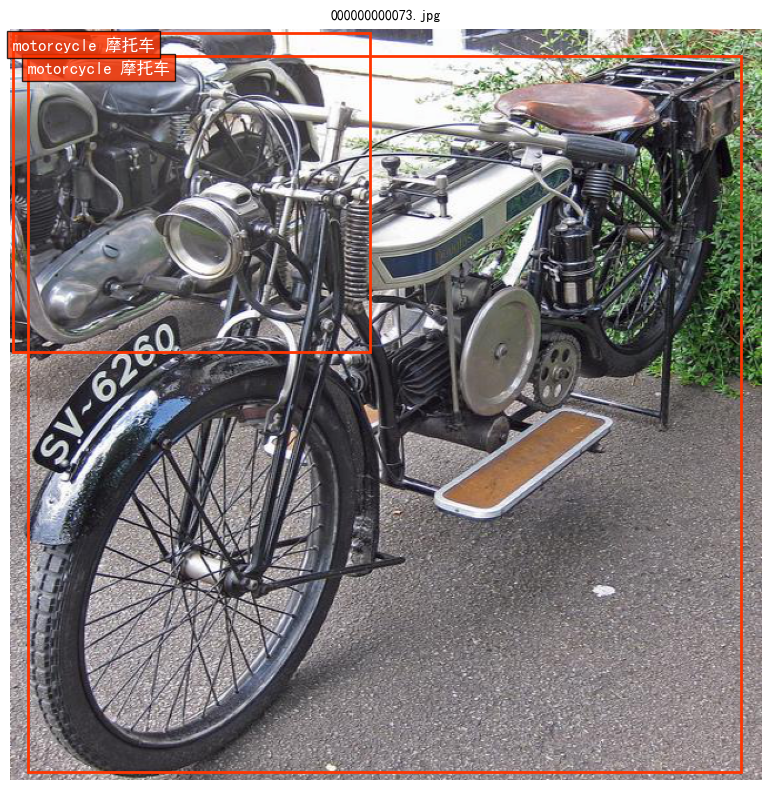


图像 2: 000000000394.jpg
标签数量: 2
标签内容:
类别: dog 狗, 坐标: [0.48891401290893555, 0.4948689937591553, 0.9778280258178711, 0.9368090033531189]
类别: frisbee 飞盘, 坐标: [0.6454449892044067, 0.5424630045890808, 0.5554220080375671, 0.4778890013694763]


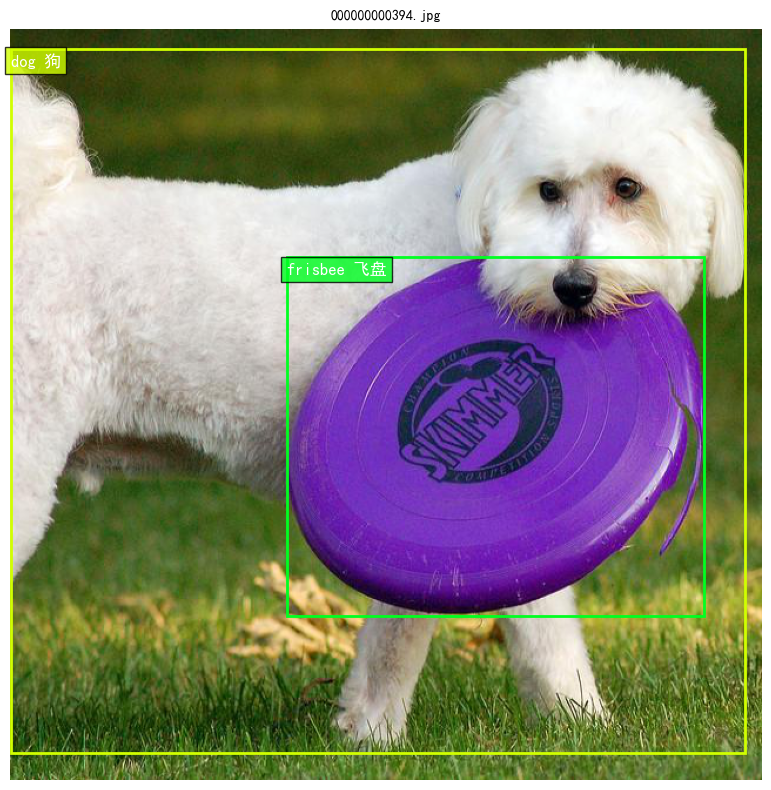


图像 3: 000000000081.jpg
标签数量: 1
标签内容:
类别: airplane 飞机, 坐标: [0.5164920091629028, 0.4693880081176758, 0.9125159978866577, 0.7482820153236389]


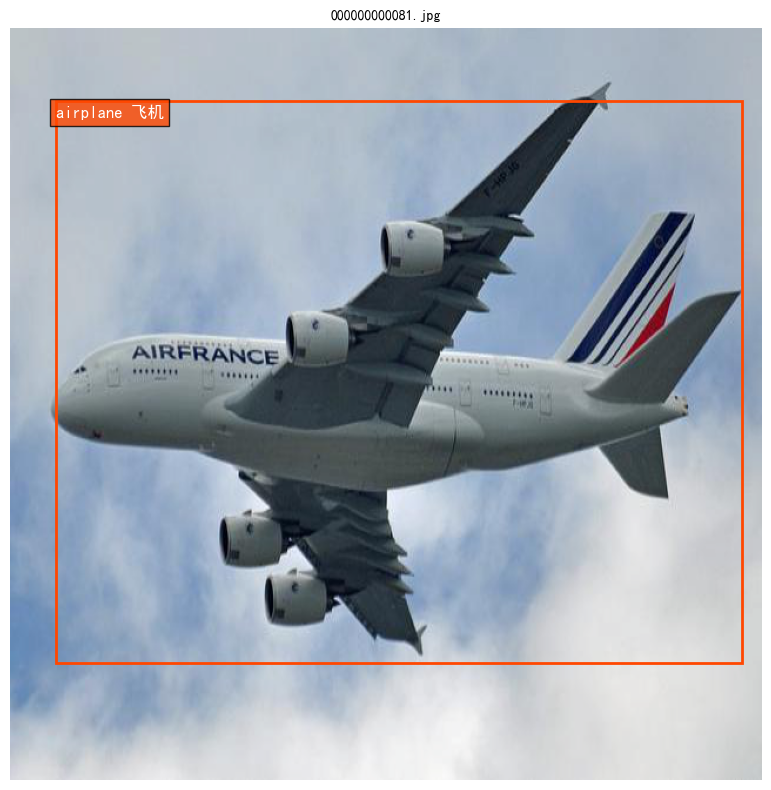


图像 4: 000000000086.jpg
标签数量: 3
标签内容:
类别: person 人, 坐标: [0.42321300506591797, 0.5798199772834778, 0.2522459924221039, 0.5874530076980591]
类别: motorcycle 摩托车, 坐标: [0.5415430068969727, 0.7669370174407959, 0.5747269988059998, 0.45100000500679016]
类别: handbag 手提包, 坐标: [0.6492189764976501, 0.5463749766349792, 0.2628909945487976, 0.17215600609779358]


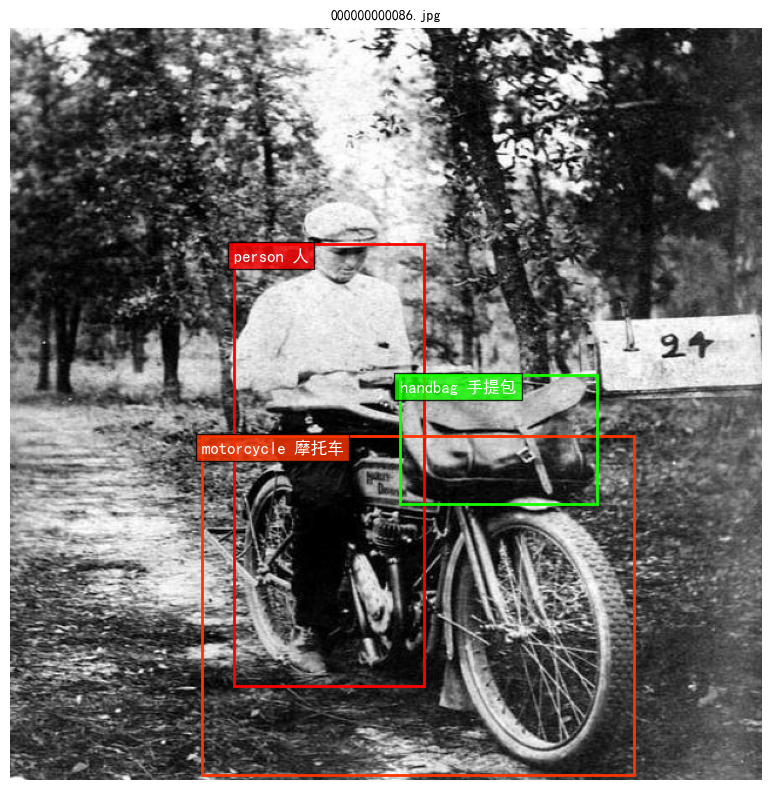


可视化测试完成!


In [23]:
def setup_matplotlib_fonts():
    """设置matplotlib字体配置"""
    # 指定字体文件路径
    font_path = '../resource/SimHei.ttf'
    
    if os.path.exists(font_path):
        # 创建FontProperties对象
        font_prop = fm.FontProperties(fname=font_path)
        
        # # 清除字体缓存
        # fm._rebuild()
        
        # 设置全局字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 只使用SimHei
        plt.rcParams['axes.unicode_minus'] = False
        
        # 更新默认字体属性
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['font.serif'] = ['SimHei']
        
        # # 删除其他字体回退选项
        # plt.rcParams['font.fallback'] = []
        
        return font_prop
    else:
        print(f"Warning: Font file not found at {font_path}")
        return None

# 在代码开始时调用此函数
font_prop = setup_matplotlib_fonts()

# COCO类别名称（添加中文翻译）
COCO_CLASSES = {
    0: 'person 人', 1: 'bicycle 自行车', 2: 'car 汽车', 3: 'motorcycle 摩托车', 
    4: 'airplane 飞机', 5: 'bus 公交车', 6: 'train 火车', 7: 'truck 卡车', 
    8: 'boat 船', 9: 'traffic light 红绿灯', 10: 'fire hydrant 消防栓', 
    11: 'stop sign 停止标志', 12: 'parking meter 停车计时器', 13: 'bench 长椅',
    14: 'bird 鸟', 15: 'cat 猫', 16: 'dog 狗', 17: 'horse 马', 
    18: 'sheep 羊', 19: 'cow 牛', 20: 'elephant 大象', 21: 'bear 熊', 
    22: 'zebra 斑马', 23: 'giraffe 长颈鹿', 24: 'backpack 背包', 
    25: 'umbrella 雨伞', 26: 'handbag 手提包', 27: 'tie 领带', 
    28: 'suitcase 手提箱', 29: 'frisbee 飞盘', 30: 'skis 滑雪板', 
    31: 'snowboard 单板滑雪', 32: 'sports ball 运动球', 33: 'kite 风筝', 
    34: 'baseball bat 棒球棒', 35: 'baseball glove 棒球手套', 
    36: 'skateboard 滑板', 37: 'surfboard 冲浪板', 
    38: 'tennis racket 网球拍', 39: 'bottle 瓶子', 
    40: 'wine glass 酒杯', 41: 'cup 杯子', 42: 'fork 叉子', 
    43: 'knife 刀', 44: 'spoon 勺子', 45: 'bowl 碗', 46: 'banana 香蕉', 
    47: 'apple 苹果', 48: 'sandwich 三明治', 49: 'orange 橙子', 
    50: 'broccoli 西兰花', 51: 'carrot 胡萝卜', 52: 'hot dog 热狗', 
    53: 'pizza 披萨', 54: 'donut 甜甜圈', 55: 'cake 蛋糕', 
    56: 'chair 椅子', 57: 'couch 沙发', 58: 'potted plant 盆栽', 
    59: 'bed 床', 60: 'dining table 餐桌', 61: 'toilet 马桶', 
    62: 'tv 电视', 63: 'laptop 笔记本电脑', 64: 'mouse 鼠标', 
    65: 'remote 遥控器', 66: 'keyboard 键盘', 67: 'cell phone 手机', 
    68: 'microwave 微波炉', 69: 'oven 烤箱', 70: 'toaster 烤面包机', 
    71: 'sink 水槽', 72: 'refrigerator 冰箱', 73: 'book 书', 
    74: 'clock 时钟', 75: 'vase 花瓶', 76: 'scissors 剪刀', 
    77: 'teddy bear 泰迪熊', 78: 'hair drier 吹风机', 
    79: 'toothbrush 牙刷'
}

def plot_image_with_boxes(image, labels, img_name=None, class_names=None, figsize=(10,10)):
    """
    可视化图像和边界框（支持中文）
    
    Args:
        image: torch.Tensor (C, H, W) - 归一化后的图像
        labels: torch.Tensor (num_objects, 5) - [class, x_center, y_center, width, height]
        img_name: str - 图像文件名
        class_names: dict - 类别ID到名称的映射
        figsize: tuple - 图像显示大小
    """
    plt.rcParams['font.family'] = ['SimHei']
    
    # 转换图像格式
    img = image.permute(1, 2, 0).numpy()
    
    # 反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # 创建图形
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    
    # 获取图像尺寸
    height, width = img.shape[:2]
    
    # 设置不同类别的颜色
    colors = plt.cm.hsv(np.linspace(0, 1, 81))[:, :3]
    
    # 绘制每个边界框
    for label in labels:
        class_id = int(label[0])
        x_center = float(label[1]) * width
        y_center = float(label[2]) * height
        w = float(label[3]) * width
        h = float(label[4]) * height
        
        # 计算左上角坐标
        x = x_center - w/2
        y = y_center - h/2
        
        # 获取该类别的颜色
        color = colors[class_id % len(colors)]
        
        # 创建矩形
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 添加类别标签（中英文）
        if class_names is not None and class_id in class_names:
            class_name = class_names[class_id]
        else:
            class_name = f'class_{class_id}'
            
        # 绘制标签背景框
        plt.text(
            x, y+15,
            class_name,
            bbox=dict(facecolor=color, alpha=0.8),
            color='white',
            fontsize=12,
            fontproperties=font_prop if font_prop else None
        )
    
    # 添加图像标题
    if img_name:
        plt.title(img_name, fontproperties=font_prop if font_prop else None)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

# 测试代码
def test_visualization(batch_size=4, img_size=640,batch_num=0):
    """测试数据加载器和可视化（支持中文）"""
    print("开始测试数据加载器和可视化...")
    
    # 创建数据加载器
    train_img_dir = "../datasets/coco128/images"
    train_label_dir = "../datasets/coco128/labels"
    
    train_loader = create_dataloader3(
        train_img_dir,
        train_label_dir,
        batch_size=batch_size,
        img_size=img_size,
        augment=True
    )
    
    for batch_i, (imgs, targets, img_names) in enumerate(train_loader):
        if batch_i == batch_num:
            print(f"\n批次 {batch_i + 1}:")
            print(f"图像张量形状: {imgs.shape}")
            print(f"批次中的图像数量: {len(targets)}")
            
            for i in range(len(imgs)):
                print(f"\n图像 {i + 1}: {img_names[i]}")
                print(f"标签数量: {len(targets[i])}")
                
                if len(targets[i]) > 0:
                    print("标签内容:")
                    for label in targets[i]:
                        class_id = int(label[0])
                        class_name = COCO_CLASSES.get(class_id, f'class_{class_id}')
                        print(f"类别: {class_name}, 坐标: {label[1:].tolist()}")
                
                plot_image_with_boxes(
                    imgs[i], 
                    targets[i],
                    img_names[i],
                    COCO_CLASSES,
                    figsize=(8,8)
                )
            
            break
    
    print("\n可视化测试完成!")

if __name__ == "__main__":
    test_visualization()

开始测试数据加载器和可视化...

批次 2:
图像张量形状: torch.Size([4, 3, 640, 640])
批次中的图像数量: 4

图像 1: 000000000034.jpg
标签数量: 1
标签内容:
类别: zebra 斑马, 坐标: [0.3462109863758087, 0.4932590126991272, 0.6894220113754272, 0.892117977142334]


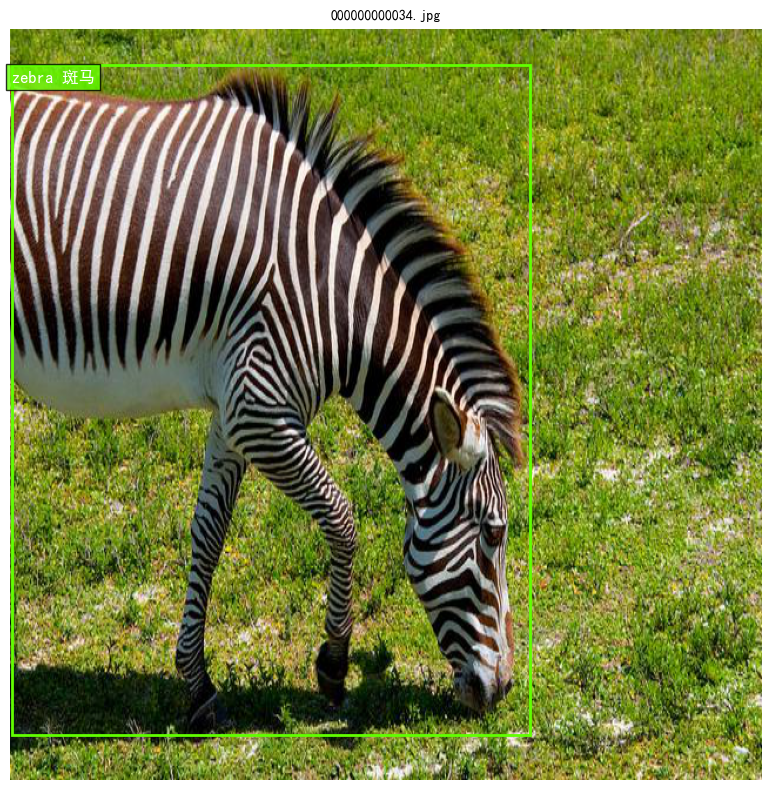


图像 2: 000000000544.jpg
标签数量: 16
标签内容:
类别: sports ball 运动球, 坐标: [0.9429299831390381, 0.6967210173606873, 0.021578099578619003, 0.017423899844288826]
类别: person 人, 坐标: [0.4842729866504669, 0.7595549821853638, 0.1769219934940338, 0.3775179982185364]
类别: person 人, 坐标: [0.2691250145435333, 0.8359599709510803, 0.20240600407123566, 0.2606790065765381]
类别: person 人, 坐标: [0.11931999772787094, 0.7978569865226746, 0.1588589996099472, 0.33440300822257996]
类别: person 人, 坐标: [0.14164100587368011, 0.5012879967689514, 0.04506250098347664, 0.1048709973692894]
类别: person 人, 坐标: [0.4091799855232239, 0.49284499883651733, 0.04557809978723526, 0.11711899936199188]
类别: person 人, 坐标: [0.3252499997615814, 0.5239930152893066, 0.046937499195337296, 0.06447310000658035]
类别: person 人, 坐标: [0.25700798630714417, 0.5027869939804077, 0.0486719012260437, 0.09831380099058151]
类别: person 人, 坐标: [0.026265600696206093, 0.6091799736022949, 0.05231250077486038, 0.182436004281044]
类别: person 人, 坐标: [0.8682500123977661, 0.520

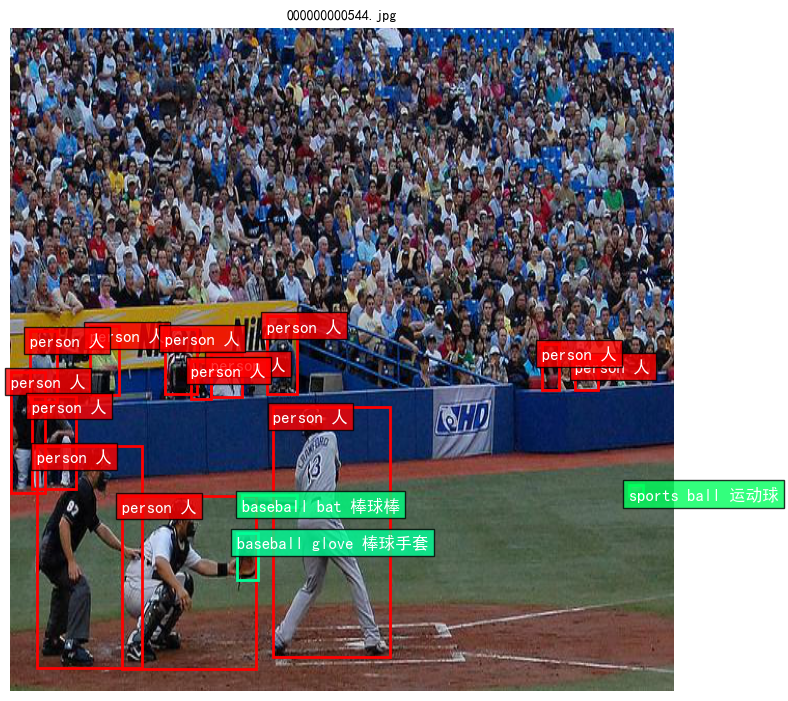


图像 3: 000000000589.jpg
标签数量: 2
标签内容:
类别: frisbee 飞盘, 坐标: [0.7394300103187561, 0.484499990940094, 0.02929689921438694, 0.013124999590218067]
类别: person 人, 坐标: [0.6572269797325134, 0.5764899849891663, 0.22723400592803955, 0.3839370012283325]


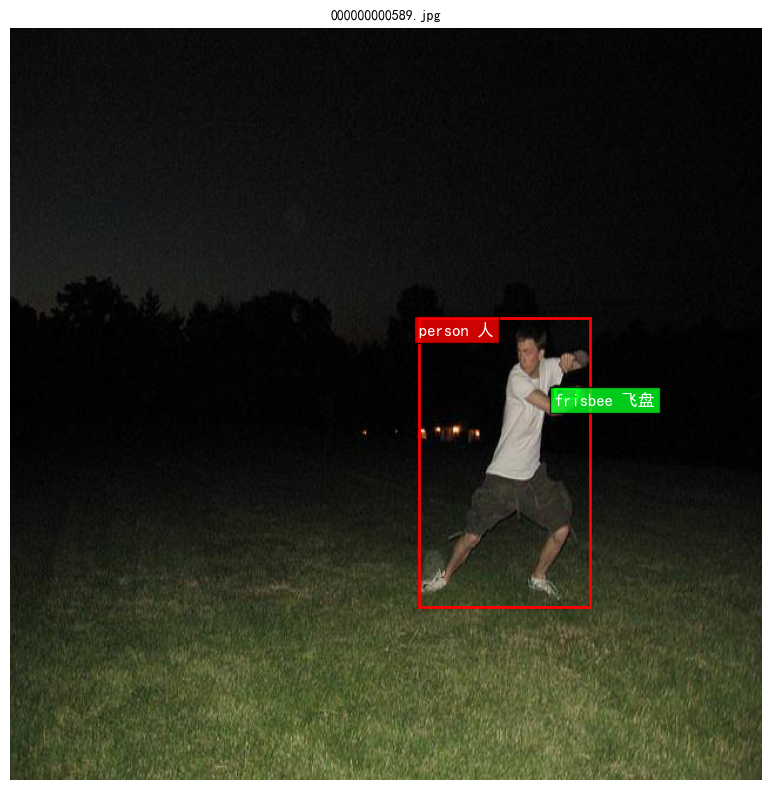


图像 4: 000000000315.jpg
标签数量: 38
标签内容:
类别: umbrella 雨伞, 坐标: [0.18675799667835236, 0.3783720135688782, 0.33142200112342834, 0.31074899435043335]
类别: umbrella 雨伞, 坐标: [0.34183600544929504, 0.37796300649642944, 0.23989099264144897, 0.20899300277233124]
类别: umbrella 雨伞, 坐标: [0.41735899448394775, 0.3449769914150238, 0.2006250023841858, 0.16653400659561157]
类别: umbrella 雨伞, 坐标: [0.49146100878715515, 0.35619398951530457, 0.10595300048589706, 0.09740050137042999]
类别: umbrella 雨伞, 坐标: [0.5087730288505554, 0.2925179898738861, 0.1392969936132431, 0.04817330092191696]
类别: umbrella 雨伞, 坐标: [0.6252110004425049, 0.34374698996543884, 0.07773440331220627, 0.05789230018854141]
类别: umbrella 雨伞, 坐标: [0.6922190189361572, 0.20532800257205963, 0.05971879884600639, 0.21046799421310425]
类别: umbrella 雨伞, 坐标: [0.12463299930095673, 0.5317450165748596, 0.24926599860191345, 0.6107490062713623]
类别: umbrella 雨伞, 坐标: [0.06146879866719246, 0.4505620002746582, 0.12293799966573715, 0.25840699672698975]
类别: umbrella 雨伞, 坐

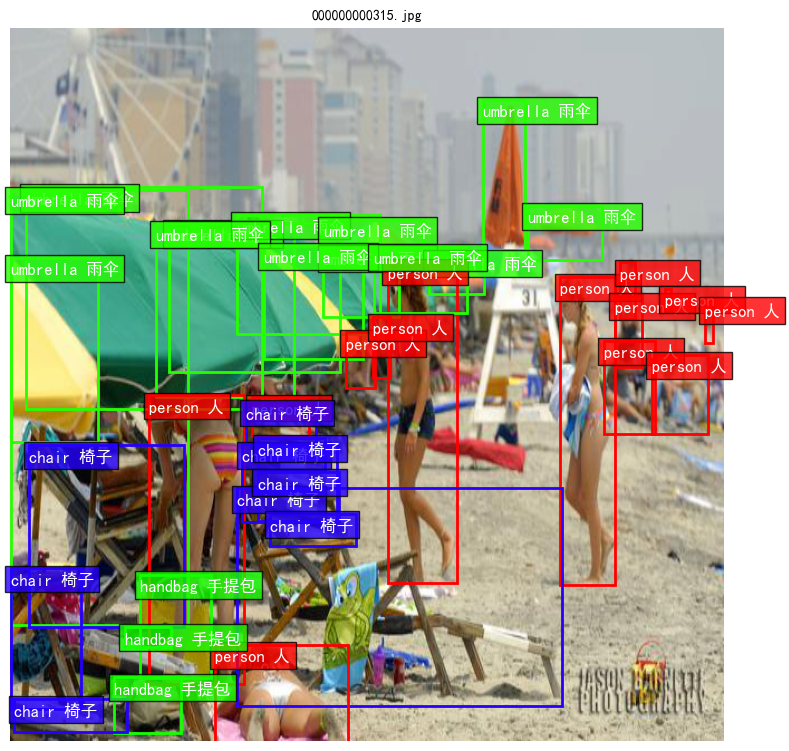


可视化测试完成!


In [24]:
test_visualization(batch_size=4, img_size=640,batch_num=1)

## YOLOLoss

- 介绍函数功能：
    - 计算YOLO损失
- 参数：
    - predictions: [batch_size, num_boxes, 5+num_classes] 格式的预测
    - targets: [batch_size, max_objects, 5] 格式的目标框 (class_id, x, y, w, h)
- 函数
    - __init__: 初始化YOLO损失
    - forward: 计算YOLO损失
    - box_iou: 计算两组框之间的IoU
- **算法步骤**
    - 分离预测的组件
    - 计算IoU
    - 为每个目标找到最佳预测框
    - 定位损失（只针对最佳匹配的框）
    - 置信度损失
    - 类别损失（只针对最佳匹配的框）
    - 总损失
- 返回：
    - 平均损失


In [25]:
class YOLOLoss(nn.Module):
    def __init__(self, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.lambda_coord = 5.0
        self.lambda_noobj = 0.5
        
    def forward(self, predictions, targets):
        """
        计算YOLO损失
        Args:
            predictions: [batch_size, num_boxes, 5+num_classes] 格式的预测
            targets: [batch_size, max_objects, 5] 格式的目标框 (class_id, x, y, w, h)
        """
        batch_size = predictions.size(0)
        total_loss = torch.tensor(0.0, device=predictions.device, dtype=predictions.dtype)
        
        # 分离预测的组件
        pred_boxes = predictions[..., :4]  # [batch_size, num_boxes, 4]
        pred_conf = predictions[..., 4]    # [batch_size, num_boxes]
        pred_cls = predictions[..., 5:]    # [batch_size, num_boxes, num_classes]
        
        for i in range(batch_size):
            # 获取当前批次的目标
            curr_targets = targets[i]
            valid_targets = curr_targets[curr_targets[:, 0] >= 0]  # 过滤掉填充的目标
            
            if len(valid_targets) == 0:
                # 如果没有目标，只计算置信度损失
                conf_loss = self.bce_loss(
                    pred_conf[i], 
                    torch.zeros_like(pred_conf[i], dtype=predictions.dtype)
                )
                total_loss += self.lambda_noobj * conf_loss
                continue
            
            # 计算IoU
            ious = self.box_iou(pred_boxes[i], valid_targets[:, 1:])  # [num_boxes, num_targets]
            
            # 为每个目标找到最佳预测框
            best_ious, best_box_idx = ious.max(dim=0)  # [num_targets]
            
            # 定位损失（只针对最佳匹配的框）
            box_loss = self.mse_loss(
                pred_boxes[i][best_box_idx],
                valid_targets[:, 1:].to(dtype=predictions.dtype)
            )
            
            # 置信度损失
            conf_targets = torch.zeros_like(pred_conf[i], dtype=predictions.dtype)
            conf_targets[best_box_idx] = best_ious.to(dtype=predictions.dtype)
            conf_loss = self.bce_loss(pred_conf[i], conf_targets)
            
            # 类别损失（只针对最佳匹配的框）
            cls_targets = torch.zeros_like(pred_cls[i], dtype=predictions.dtype)
            cls_targets[best_box_idx, valid_targets[:, 0].long()] = 1
            cls_loss = self.bce_loss(pred_cls[i], cls_targets)
            
            # 总损失
            total_loss += (
                self.lambda_coord * box_loss +
                conf_loss +
                cls_loss
            )
        
        return total_loss / batch_size
    
    def box_iou(self, box1, box2):
        """
        计算两组框之间的IoU
        Args:
            box1: [N, 4] 第一组框 (x, y, w, h)
            box2: [M, 4] 第二组框 (x, y, w, h)
        Returns:
            IoU: [N, M] IoU矩阵
        """
        # 转换为左上角和右下角坐标
        b1_x1 = box1[:, 0] - box1[:, 2] / 2
        b1_y1 = box1[:, 1] - box1[:, 3] / 2
        b1_x2 = box1[:, 0] + box1[:, 2] / 2
        b1_y2 = box1[:, 1] + box1[:, 3] / 2
        
        b2_x1 = box2[:, 0] - box2[:, 2] / 2
        b2_y1 = box2[:, 1] - box2[:, 3] / 2
        b2_x2 = box2[:, 0] + box2[:, 2] / 2
        b2_y2 = box2[:, 1] + box2[:, 3] / 2
        
        # 计算交集区域
        inter_x1 = torch.max(b1_x1.unsqueeze(1), b2_x1)
        inter_y1 = torch.max(b1_y1.unsqueeze(1), b2_y1)
        inter_x2 = torch.min(b1_x2.unsqueeze(1), b2_x2)
        inter_y2 = torch.min(b1_y2.unsqueeze(1), b2_y2)
        
        inter_w = torch.clamp(inter_x2 - inter_x1, min=0)
        inter_h = torch.clamp(inter_y2 - inter_y1, min=0)
        inter_area = inter_w * inter_h
        
        # 计算并集区域
        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
        union_area = b1_area.unsqueeze(1) + b2_area - inter_area
        
        # 计算IoU
        iou = inter_area / (union_area + 1e-16)
        return iou

## YOLOv3 Model

**主要参考 YOLOv3-in-PyTorch**

https://github.com/westerndigitalcorporation/YOLOv3-in-PyTorch/blob/release/src/model.py

**模型结构**

- DarkNet53BackBone (Backbone)
- YoloNetTail (Neck+Head)
- YoloNetV3 (Model)

目前的结构对backbone的输出进行了3次下采样，然后进行concat，再进行3次上采样，最后进行3次下采样，得到最终的输出。
Neck部分不是很清晰， 后面考虑优化下


### ConvLayer
- 介绍函数功能
    - 创建一个卷积层，包括卷积层、批归一化层和LeakyReLU层
- 参数
    - in_channels: 输入通道数
    - out_channels: 输出通道数
    - kernel_size: 卷积核大小
    - stride: 步幅
    - lrelu_neg_slope: LeakyReLU的负斜率
- 返回
    - 输出张量

### ResBlock
- 介绍函数功能
    - 创建一个残差块，包括两个卷积层
- 参数
    - in_channels: 输入通道数
- 返回
    - 输出张量

### make_conv_and_res_block
- 介绍函数功能
    - 创建一个卷积层和一个残差块
- 参数
    - in_channels: 输入通道数
    - out_channels: 输出通道数
    - res_repeat: 残差块重复次数
- 返回
    - 输出张量

### YoloLayer （Used in DetectionBlock）
- 介绍函数功能
    - 创建一个**YOLO层**，包括**锚点、步幅和前向传播**
    - **锚点**：锚点是预先定义的参考框，用于预测目标的位置和大小
    - **步幅**：步幅是特征图的缩放比例，用于将特征图的坐标映射到原始图像的坐标
    - **前向传播**：前向传播是YOLO网络的输出，包括预测框、置信度和类别
    
- 参数
    - scale: 尺度
    - stride: 步幅
- 返回
    - 输出张量

### DetectionBlock (类似Neck， 但是没有concat，输出一路head的feature)
- 介绍函数功能
    - 创建一个检测块，包括六个卷积层、一个卷积层和一个YOLO层
- 参数
    - in_channels: 输入通道数
    - out_channels: 输出通道数
    - scale: 尺度
    - stride: 步幅
- 返回
    - 输出张量

### DarkNet53BackBone (Backbone)
- 介绍函数功能
    - 创建一个DarkNet53骨干网络，包括五个卷积层和残差块
- 参数
    - 无
- 返回
    - 输出张量

### YoloNetTail (Neck+Head)
- 介绍函数功能
    - 包括三个检测块（类似Head的三路不同scale的输出）
    - 将DarkNet53BackBone的结果进行上采样和拼接（**类似Neck**），最后输出检测结果（**类似Head**）。
- 参数
    - 无
- 返回
    - 输出张量

### YoloNetV3 (Model)
- 介绍函数功能
    - 创建一个YOLO网络，包括DarkNet53骨干网络和YOLO网络尾部
    - 将YoloNetTail和DarkNet53BackBone组装在一起，将得到最终的结果。
- 参数
    - 无
- 返回
    - 输出张量


In [26]:
# https://github.com/westerndigitalcorporation/YOLOv3-in-PyTorch/blob/release/src/model.py

import logging

import torch
import torch.nn as nn
import torch.nn.functional as F  # 这是我们需要的interpolate函数

from config import ANCHORS, NUM_ANCHORS_PER_SCALE, NUM_CLASSES, NUM_ATTRIB, LAST_LAYER_DIM

Tensor = torch.Tensor


class ConvLayer(nn.Module):
    """Basic 'conv' layer, including:
     A Conv2D layer with desired channels and kernel size,
     A batch-norm layer,
     and A leakyReLu layer with neg_slope of 0.1.
     (Didn't find too much resource what neg_slope really is.
     By looking at the darknet source code, it is confirmed the neg_slope=0.1.
     Ref: https://github.com/pjreddie/darknet/blob/master/src/activations.h)
     Please note here we distinguish between Conv2D layer and Conv layer."""

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, lrelu_neg_slope=0.1):
        super(ConvLayer, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(negative_slope=lrelu_neg_slope)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.lrelu(out)

        return out


class ResBlock(nn.Module):
    """The basic residual block used in YoloV3.
    Each ResBlock consists of two ConvLayers and the input is added to the final output.
    In YoloV3 paper, the first convLayer has half of the number of the filters as much as the second convLayer.
    The first convLayer has filter size of 1x1 and the second one has the filter size of 3x3.
    """

    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        assert in_channels % 2 == 0  # ensure the in_channels is an even number.
        half_in_channels = in_channels // 2
        self.conv1 = ConvLayer(in_channels, half_in_channels, 1)
        self.conv2 = ConvLayer(half_in_channels, in_channels, 3)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual

        return out


def make_conv_and_res_block(in_channels, out_channels, res_repeat):
    """In Darknet 53 backbone, there is usually one Conv Layer followed by some ResBlock.
    This function will make that.
    The Conv layers always have 3x3 filters with stride=2.
    The number of the filters in Conv layer is the same as the out channels of the ResBlock"""
    model = nn.Sequential()
    model.add_module('conv', ConvLayer(in_channels, out_channels, 3, stride=2))
    for idx in range(res_repeat):
        model.add_module('res{}'.format(idx), ResBlock(out_channels))
    return model


class YoloLayer(nn.Module):
    """
    创建一个YOLO层，包括锚点、步幅和前向传播
    - 锚点：锚点是预先定义的参考框，用于预测目标的位置和大小
    - 步幅：步幅是特征图的缩放比例，用于将特征图的坐标映射到原始图像的坐标
    - 前向传播：前向传播是YOLO网络的输出，包括预测框、置信度和类别
    """

    def __init__(self, scale, stride):
        super(YoloLayer, self).__init__()
        if scale == 's':
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            idx = None
        self.anchors = torch.tensor([ANCHORS[i] for i in idx])
        self.stride = stride

    def forward(self, x):
        num_batch = x.size(0)
        num_grid = x.size(2)

        if self.training:
            output_raw = x.view(num_batch,
                                NUM_ANCHORS_PER_SCALE,
                                NUM_ATTRIB,
                                num_grid,
                                num_grid).permute(0, 1, 3, 4, 2).contiguous().view(num_batch, -1, NUM_ATTRIB)
            return output_raw
        else:
            prediction_raw = x.view(num_batch,
                                    NUM_ANCHORS_PER_SCALE,
                                    NUM_ATTRIB,
                                    num_grid,
                                    num_grid).permute(0, 1, 3, 4, 2).contiguous()

            self.anchors = self.anchors.to(x.device).float()
            # Calculate offsets for each grid
            grid_tensor = torch.arange(num_grid, dtype=torch.float, device=x.device).repeat(num_grid, 1)
            grid_x = grid_tensor.view([1, 1, num_grid, num_grid])
            grid_y = grid_tensor.t().view([1, 1, num_grid, num_grid])
            anchor_w = self.anchors[:, 0:1].view((1, -1, 1, 1))
            anchor_h = self.anchors[:, 1:2].view((1, -1, 1, 1))

            # Get outputs
            x_center_pred = (torch.sigmoid(prediction_raw[..., 0]) + grid_x) * self.stride # Center x
            y_center_pred = (torch.sigmoid(prediction_raw[..., 1]) + grid_y) * self.stride  # Center y
            w_pred = torch.exp(prediction_raw[..., 2]) * anchor_w  # Width
            h_pred = torch.exp(prediction_raw[..., 3]) * anchor_h  # Height
            bbox_pred = torch.stack((x_center_pred, y_center_pred, w_pred, h_pred), dim=4).view((num_batch, -1, 4)) #cxcywh
            conf_pred = torch.sigmoid(prediction_raw[..., 4]).view(num_batch, -1, 1)  # Conf
            cls_pred = torch.sigmoid(prediction_raw[..., 5:]).view(num_batch, -1, NUM_CLASSES)  # Cls pred one-hot.

            output = torch.cat((bbox_pred, conf_pred, cls_pred), -1)
            return output


class DetectionBlock(nn.Module):
    """The DetectionBlock contains:
    Six ConvLayers, 1 Conv2D Layer and 1 YoloLayer.
    The first 6 ConvLayers are formed the following way:
    1x1xn, 3x3x2n, 1x1xn, 3x3x2n, 1x1xn, 3x3x2n,
    The Conv2D layer is 1x1x255.
    Some block will have branch after the fifth ConvLayer.
    The input channel is arbitrary (in_channels)
    out_channels = n
    """

    def __init__(self, in_channels, out_channels, scale, stride):
        super(DetectionBlock, self).__init__()
        assert out_channels % 2 == 0  #assert out_channels is an even number
        half_out_channels = out_channels // 2
        self.conv1 = ConvLayer(in_channels, half_out_channels, 1)
        self.conv2 = ConvLayer(half_out_channels, out_channels, 3)
        self.conv3 = ConvLayer(out_channels, half_out_channels, 1)
        self.conv4 = ConvLayer(half_out_channels, out_channels, 3)
        self.conv5 = ConvLayer(out_channels, half_out_channels, 1)
        self.conv6 = ConvLayer(half_out_channels, out_channels, 3)
        self.conv7 = nn.Conv2d(out_channels, LAST_LAYER_DIM, 1, bias=True)
        self.yolo = YoloLayer(scale, stride)

    def forward(self, x):
        tmp = self.conv1(x)
        tmp = self.conv2(tmp)
        tmp = self.conv3(tmp)
        tmp = self.conv4(tmp)
        self.branch = self.conv5(tmp)
        tmp = self.conv6(self.branch)
        tmp = self.conv7(tmp)
        out = self.yolo(tmp)

        return out


class DarkNet53BackBone(nn.Module):

    def __init__(self):
        super(DarkNet53BackBone, self).__init__()
        self.conv1 = ConvLayer(3, 32, 3)
        self.cr_block1 = make_conv_and_res_block(32, 64, 1)
        self.cr_block2 = make_conv_and_res_block(64, 128, 2)
        self.cr_block3 = make_conv_and_res_block(128, 256, 8)
        self.cr_block4 = make_conv_and_res_block(256, 512, 8)
        self.cr_block5 = make_conv_and_res_block(512, 1024, 4)

    def forward(self, x):
        tmp = self.conv1(x)
        tmp = self.cr_block1(tmp)
        tmp = self.cr_block2(tmp)
        out3 = self.cr_block3(tmp)
        out2 = self.cr_block4(out3)
        out1 = self.cr_block5(out2)

        return out1, out2, out3


class YoloNetTail(nn.Module):

    """The tail side of the YoloNet.
    It will take the result from DarkNet53BackBone and do some upsampling and concatenation.
    It will finally output the detection result.
    Assembling YoloNetTail and DarkNet53BackBone will give you final result
    中文：
    这个类是YOLO网络的尾部，它将DarkNet53BackBone的结果进行上采样和拼接，最后输出检测结果。
    将YoloNetTail和DarkNet53BackBone组装在一起，将得到最终的结果。
    """

    def __init__(self):
        super(YoloNetTail, self).__init__()
        self.detect1 = DetectionBlock(1024, 1024, 'l', 32)
        self.conv1 = ConvLayer(512, 256, 1)
        self.detect2 = DetectionBlock(768, 512, 'm', 16)
        self.conv2 = ConvLayer(256, 128, 1)
        self.detect3 = DetectionBlock(384, 256, 's', 8)

    def forward(self, x1, x2, x3):
        out1 = self.detect1(x1)
        branch1 = self.detect1.branch
        tmp = self.conv1(branch1)
        tmp = F.interpolate(tmp, scale_factor=2)
        tmp = torch.cat((tmp, x2), 1)
        out2 = self.detect2(tmp)
        branch2 = self.detect2.branch
        tmp = self.conv2(branch2)
        tmp = F.interpolate(tmp, scale_factor=2)
        tmp = torch.cat((tmp, x3), 1)
        out3 = self.detect3(tmp)

        return out1, out2, out3


class YoloNetV3(nn.Module):

    def __init__(self, nms=False, post=True):
        super(YoloNetV3, self).__init__()
        self.darknet = DarkNet53BackBone()
        self.yolo_tail = YoloNetTail()
        self.nms = nms
        self._post_process = post

    def forward(self, x):
        tmp1, tmp2, tmp3 = self.darknet(x)
        out1, out2, out3 = self.yolo_tail(tmp1, tmp2, tmp3)
        out = torch.cat((out1, out2, out3), 1)
        logging.debug("The dimension of the output before nms is {}".format(out.size()))
        return out

    def yolo_last_layers(self):
        _layers = [self.yolo_tail.detect1.conv7,
                   self.yolo_tail.detect2.conv7,
                   self.yolo_tail.detect3.conv7]
        return _layers

    def yolo_last_two_layers(self):
        _layers = self.yolo_last_layers() + \
                  [self.yolo_tail.detect1.conv6,
                   self.yolo_tail.detect2.conv6,
                   self.yolo_tail.detect3.conv6]
        return _layers

    def yolo_last_three_layers(self):
        _layers = self.yolo_last_two_layers() + \
                  [self.yolo_tail.detect1.conv5,
                   self.yolo_tail.detect2.conv5,
                   self.yolo_tail.detect3.conv5]
        return _layers

    def yolo_tail_layers(self):
        _layers = [self.yolo_tail]
        return _layers

    def yolo_last_n_layers(self, n):
        try:
            n = int(n)
        except ValueError:
            pass
        if n == 1:
            return self.yolo_last_layers()
        elif n == 2:
            return self.yolo_last_two_layers()
        elif n == 3:
            return self.yolo_last_three_layers()
        elif n == 'tail':
            return self.yolo_tail_layers()
        else:
            raise ValueError("n>3 not defined")

### test_yolov3_output_shape测试函数

- 介绍函数功能
    - 测试YOLO网络的输出形状
- 参数
    - 无
- 返回
    - 输出张量


In [27]:
def test_yolov3_output_shape():
    # 创建输入张量
    batch_size = 1
    channels = 3
    height = 640
    width = 640
    input_tensor = torch.randn(batch_size, channels, height, width)
    
    # 创建模型
    model = YoloNetV3()
    model.eval()  # 设置为评估模式
    
    # 前向传播
    with torch.no_grad():
        output = model(input_tensor)
    
    # 打印输出形状
    print(f"Input shape: {input_tensor.shape}")
    print(f"Output shape: {output.shape}")
    
    # 计算每个尺度的网格大小和预测框数量
    stride_list = [32, 16, 8]  # large, medium, small scales
    for i, stride in enumerate(stride_list):
        grid_size = height // stride
        num_boxes = grid_size * grid_size * NUM_ANCHORS_PER_SCALE
        print(f"\nScale {i+1} (stride={stride}):")
        print(f"Grid size: {grid_size}x{grid_size}")
        print(f"Number of boxes per scale: {num_boxes}")
    
    # 计算总预测框数量
    total_boxes = sum([(height // stride) ** 2 * NUM_ANCHORS_PER_SCALE for stride in stride_list])
    print(f"\nTotal number of prediction boxes: {total_boxes}")
    print(f"Number of attributes per box: {NUM_ATTRIB} (4 for bbox + 1 for objectness + {NUM_CLASSES} for classes)")

if __name__ == "__main__":
    test_yolov3_output_shape()

Input shape: torch.Size([1, 3, 640, 640])
Output shape: torch.Size([1, 25200, 85])

Scale 1 (stride=32):
Grid size: 20x20
Number of boxes per scale: 1200

Scale 2 (stride=16):
Grid size: 40x40
Number of boxes per scale: 4800

Scale 3 (stride=8):
Grid size: 80x80
Number of boxes per scale: 19200

Total number of prediction boxes: 25200
Number of attributes per box: 85 (4 for bbox + 1 for objectness + 80 for classes)


对于输入形状为 (1, 3, 640, 640) 的情况，预期输出：
- 大尺度特征图 (stride=32):
    - 网格大小: 20x20
    - 每个网格 3 个锚框
    - 预测框数量: 20 20 3 = 1,200

- 中尺度特征图 (stride=16):
    - 网格大小: 40x40
    - 每个网格 3 个锚框
    - 预测框数量: 40 40 3 = 4,800

- 小尺度特征图 (stride=8):
    - 网格大小: 80x80
    - 每个网格 3 个锚框
    - 预测框数量: 80 80 3 = 19,200

总预测框数量: 25,200 (1,200 + 4,800 + 19,200)

每个预测框包含:
    - 4 个边界框坐标 (x, y, w, h)
    - 1 个目标置信度分数
    - NUM_CLASSES 个类别概率

因此最终输出张量的形状应该是:(1, 25200, 5+NUM_CLASSES)

这个测试函数会帮助你验证模型的输出维度是否符合预期，并提供详细的维度分析。

## YOLOEvaluator

### low_confidence_suppression
- 介绍函数功能：
    - 抑制低置信度的预测
- 参数：
    - predictions: [batch_size, 25200, 85] 格式的预测
- 返回：
    - 抑制低置信度的预测后的结果

### non_max_suppression
- 介绍函数功能：
    - 非极大值抑制                    
- 参数：
    - predictions: [batch_size, 25200, 85] 格式的预测
- 返回：
    - 非极大值抑制后的结果

### calculate_map
- 介绍函数功能：
    - 计算mAP
- 参数：
    - predictions: [batch_size, 25200, 85] 格式的预测
    - targets: [batch_size, max_objects, 5] 格式的目标
- 返回：
    - mAP值

### calculate_ap
- 介绍函数功能：
    - 计算AP值        
- 参数：
    - precision: [num_boxes] 格式的精度
    - recall: [num_boxes] 格式的召回率
- 返回：
    - AP值

### box_iou
- 介绍函数功能：
    - 计算两组框之间的IoU
- 参数：
    - box1: [N, 4] 第一组框 (x, y, w, h)
    - box2: [M, 4] 第二组框 (x, y, w, h)
- 返回：
    - IoU: [N, M] IoU矩阵

### evaluate_model
- 介绍函数功能：
    - 评估模型性能
- 参数：
    - model: 模型
    - test_loader: 测试数据加载器
- 返回：
    - 平均mAP值


In [28]:
class YOLOEvaluator:
    def __init__(self, num_classes=80, confidence_threshold=0.5, iou_threshold=0.5, nms_threshold=0.3):
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.nms_threshold = nms_threshold
        self.strides = [32, 16, 8]  # large, medium, small scales
        self.num_anchors_per_scale = 3
        
    def init_scales(self, predictions):
        """根据预测输出初始化scales信息"""
        batch_size, total_boxes, _ = predictions.shape
        
        # 计算输入图像大小（假设是正方形）
        # total_boxes = sum((input_size/stride)^2 * num_anchors)
        # 25200 = (640/32)^2 * 3 + (640/16)^2 * 3 + (640/8)^2 * 3
        total_grids = total_boxes / self.num_anchors_per_scale
        input_size = int((total_grids * 512) ** 0.5)  # 512是基准值
        
        self.scales = {
            'large': {
                'grid_size': input_size // self.strides[0],
                'stride': self.strides[0],
                'anchors': (0, 1, 2)
            },
            'medium': {
                'grid_size': input_size // self.strides[1],
                'stride': self.strides[1],
                'anchors': (3, 4, 5)
            },
            'small': {
                'grid_size': input_size // self.strides[2],
                'stride': self.strides[2],
                'anchors': (6, 7, 8)
            }
        }
        
    def low_confidence_suppression(self, predictions):
        """抑制低置信度的预测"""
        # 获取置信度分数
        confidence_scores = predictions[..., 4]
        
        # 创建掩码并应用
        mask = confidence_scores <= self.confidence_threshold
        predictions = predictions.clone()
        predictions[mask] = 0
        
        return predictions
        
    def non_max_suppression(self, predictions):
        """非极大值抑制"""
        batch_size = predictions.size(0)
        nms_predictions = []
        
        for i in range(batch_size):
            batch_pred = predictions[i]  # [num_boxes, 85]
            
            # 获取置信度大于阈值的预测
            confidence = batch_pred[:, 4]
            mask = confidence > self.confidence_threshold
            
            if not mask.any():
                nms_predictions.append(batch_pred)
                continue
                
            # 提取有效预测
            filtered_pred = batch_pred[mask]
            boxes = filtered_pred[:, :4]  # [x, y, w, h]
            scores = filtered_pred[:, 4]
            classes = torch.argmax(filtered_pred[:, 5:], dim=1)
            
            # 转换框格式为 [x1, y1, x2, y2]
            boxes_xyxy = torch.zeros_like(boxes)
            boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2  # x1
            boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2  # y1
            boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2  # x2
            boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2  # y2
            
            # 对每个类别分别进行NMS
            final_boxes = []
            final_scores = []
            final_classes = []
            
            for cls in torch.unique(classes):
                cls_mask = classes == cls
                if not cls_mask.any():
                    continue
                    
                cls_boxes = boxes_xyxy[cls_mask]
                cls_scores = scores[cls_mask]
                
                # 应用NMS
                keep_idx = torchvision.ops.nms(
                    cls_boxes,
                    cls_scores,
                    self.nms_threshold
                )
                
                final_boxes.append(boxes[cls_mask][keep_idx])
                final_scores.append(scores[cls_mask][keep_idx])
                final_classes.append(torch.full_like(keep_idx, cls))
            
            if final_boxes:
                final_boxes = torch.cat(final_boxes)
                final_scores = torch.cat(final_scores)
                final_classes = torch.cat(final_classes)
                
                # 重建预测张量
                final_pred = torch.zeros_like(batch_pred)
                final_pred[:len(final_boxes), :4] = final_boxes
                final_pred[:len(final_boxes), 4] = final_scores
                final_pred[:len(final_boxes), 5:][torch.arange(len(final_boxes)), final_classes] = 1
                
                nms_predictions.append(final_pred)
            else:
                nms_predictions.append(batch_pred)
        
        return torch.stack(nms_predictions)
    
    def calculate_map(self, predictions, targets):
        """
        计算mAP
        Args:
            predictions: [batch_size, 25200, 85] 格式的预测
            targets: [batch_size, max_objects, 5] 格式的目标
        """
        # 初始化scales信息
        self.init_scales(predictions)
        
        # 应用低置信度抑制和NMS
        predictions = self.low_confidence_suppression(predictions)
        predictions = self.non_max_suppression(predictions)
        
        batch_size = predictions.size(0)
        total_map = 0.0
        
        for batch_idx in range(batch_size):
            batch_pred = predictions[batch_idx]  # [num_boxes, 85]
            batch_targets = targets[batch_idx]   # [max_objects, 5]
            
            # 过滤有效目标
            valid_targets = batch_targets[batch_targets[:, 0] >= 0]
            if len(valid_targets) == 0:
                continue
            
            # 计算每个类别的AP
            batch_ap = 0.0
            num_classes_with_targets = 0
            
            for cls in range(self.num_classes):
                # 获取当前类别的预测和目标
                cls_mask_pred = batch_pred[:, 5 + cls] > 0.5
                cls_mask_targets = valid_targets[:, 0] == cls
                
                if not cls_mask_targets.any():
                    continue
                
                cls_pred_boxes = batch_pred[cls_mask_pred, :4]
                cls_pred_scores = batch_pred[cls_mask_pred, 4]
                cls_target_boxes = valid_targets[cls_mask_targets, 1:]
                
                if len(cls_pred_boxes) == 0:
                    continue
                
                # 计算IoU
                ious = self.box_iou(cls_pred_boxes, cls_target_boxes)
                
                # 计算TP和FP
                max_ious, _ = ious.max(dim=1)
                sorted_indices = torch.argsort(cls_pred_scores, descending=True)
                tp = (max_ious[sorted_indices] > self.iou_threshold).float()
                fp = 1 - tp
                
                # 计算累积TP和FP
                tp_cumsum = torch.cumsum(tp, dim=0)
                fp_cumsum = torch.cumsum(fp, dim=0)
                
                # 计算precision和recall
                precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-16)
                recall = tp_cumsum / (len(cls_target_boxes) + 1e-16)
                
                # 计算AP
                ap = self.calculate_ap(precision, recall)
                batch_ap += ap
                num_classes_with_targets += 1
            
            if num_classes_with_targets > 0:
                batch_ap /= num_classes_with_targets
                total_map += batch_ap
        
        return total_map / batch_size
    
    def calculate_ap(self, precision, recall):
        """计算AP值"""
        ap = 0.0
        for t in torch.arange(0, 1.1, 0.1):
            if torch.sum(recall >= t) == 0:
                p = 0
            else:
                p = torch.max(precision[recall >= t])
            ap = ap + p / 11.0
        return ap
    
    def box_iou(self, box1, box2):
        """
        计算两组框之间的IoU
        Args:
            box1: [N, 4] 第一组框 (x, y, w, h)
            box2: [M, 4] 第二组框 (x, y, w, h)
        Returns:
            IoU: [N, M] IoU矩阵
        """
        # 转换为左上角和右下角坐标
        b1_x1 = box1[:, 0] - box1[:, 2] / 2
        b1_y1 = box1[:, 1] - box1[:, 3] / 2
        b1_x2 = box1[:, 0] + box1[:, 2] / 2
        b1_y2 = box1[:, 1] + box1[:, 3] / 2
        
        b2_x1 = box2[:, 0] - box2[:, 2] / 2
        b2_y1 = box2[:, 1] - box2[:, 3] / 2
        b2_x2 = box2[:, 0] + box2[:, 2] / 2
        b2_y2 = box2[:, 1] + box2[:, 3] / 2
        
        # 计算交集区域
        inter_x1 = torch.max(b1_x1.unsqueeze(1), b2_x1)
        inter_y1 = torch.max(b1_y1.unsqueeze(1), b2_y1)
        inter_x2 = torch.min(b1_x2.unsqueeze(1), b2_x2)
        inter_y2 = torch.min(b1_y2.unsqueeze(1), b2_y2)
        
        inter_w = torch.clamp(inter_x2 - inter_x1, min=0)
        inter_h = torch.clamp(inter_y2 - inter_y1, min=0)
        inter_area = inter_w * inter_h
        
        # 计算并集区域
        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
        union_area = b1_area.unsqueeze(1) + b2_area - inter_area
        
        # 计算IoU
        iou = inter_area / (union_area + 1e-16)
        return iou

def evaluate_model(model, test_loader, evaluator):
    """评估模型性能"""
    model.eval()
    mAP_sum = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_i, (imgs, targets, _) in enumerate(test_loader):
            imgs = imgs.cuda()
            targets = targets.cuda()
            
            # 前向传播
            predictions = model(imgs)
            
            # 计算mAP
            mAP = evaluator.calculate_map(predictions, targets)
            mAP_sum += mAP
            num_batches += 1
    
    # 计算平均mAP
    avg_mAP = mAP_sum / num_batches
    return avg_mAP

## YOLOV3_Lightning与可视化预测框

### YOLOV3_Lightning
- 介绍函数功能：
    - 定义YOLOV3_Lightning类，继承自pl.LightningModule
    - 包含模型、评估器、损失函数等组件
    - 定义训练和验证步骤，计算损失和mAP
    - 配置优化器和学习率调度器
- 函数：
    - `# Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.`
    - forward: 前向传播
    - training_step: 训练步骤
    - validation_step: 验证步骤
    - configure_optimizers: 配置优化器和学习率调度器
- 参数：
    - num_classes: 类别数
- 返回：
    - 无
    

### visualize_predictions
- 介绍函数功能：
    - 可视化预测框
- 参数：
    - image: [3, H, W] 图像张量
    - predictions: [N, 85] 预测结果
    - title: 图像标题
- 返回：
    - 可视化图像

### test_nms_pipeline
- 介绍函数功能：
    - 测试并可视化NMS流程
- 参数：
    - model: 模型
    - test_loader: 测试数据加载器
    - evaluator: YOLOEvaluator对象
- 返回：
    - 无


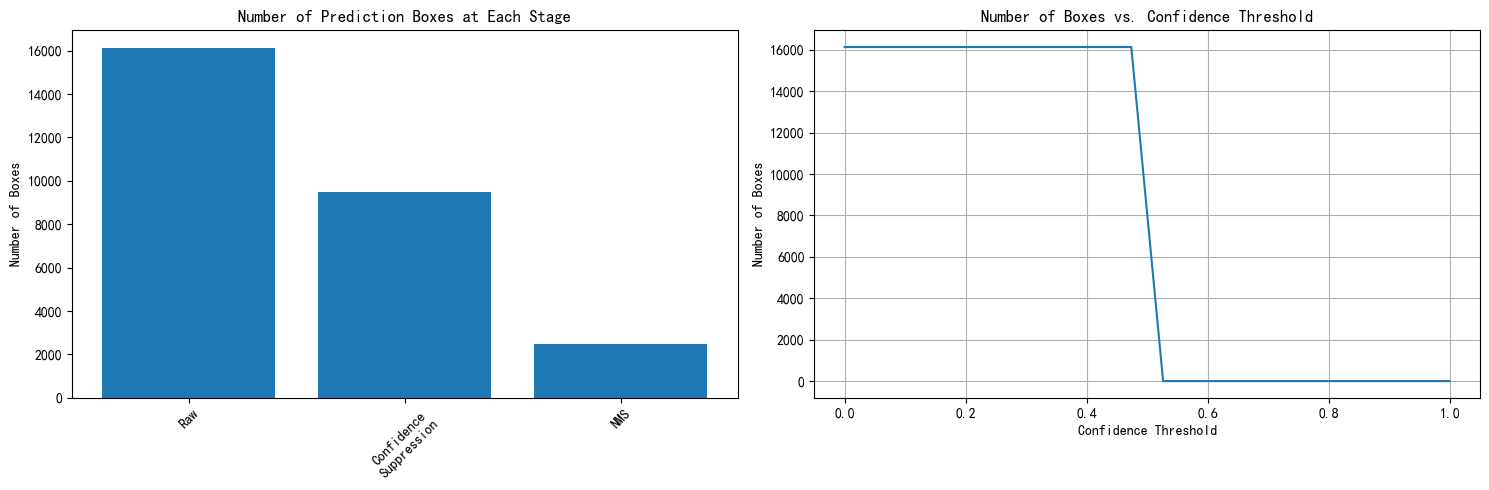


Prediction Box Statistics:
Raw predictions: 16128 boxes
After confidence suppression: 9472 boxes
After NMS: 2486 boxes

Reduction rates:
Confidence suppression: 41.3%
NMS: 73.8%
Overall: 84.6%


In [29]:
# Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.

class YOLOV3_Lightning(pl.LightningModule):
    def __init__(self, num_classes=80):
        super().__init__()
        self.model = YoloNetV3()
        self.evaluator = YOLOEvaluator(num_classes=num_classes)
        self.criterion = YOLOLoss(num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, labels, _ = batch
        
        # 处理不同长度的标签
        max_objects = max(len(label) for label in labels)
        batch_labels = torch.zeros(len(labels), max_objects, 5).to(images.device)
        for i, label in enumerate(labels):
            if len(label) > 0:  # 确保label不为空
                batch_labels[i, :len(label)] = label
        
        outputs = self(images)
        loss = self.criterion(outputs, batch_labels)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels, _ = batch
        
        # 处理不同长度的标签
        max_objects = max(len(label) for label in labels)
        batch_labels = torch.zeros(len(labels), max_objects, 5).to(images.device)
        for i, label in enumerate(labels):
            if len(label) > 0:  # 确保label不为空
                batch_labels[i, :len(label)] = label
        
        outputs = self(images)
        loss = self.criterion(outputs, batch_labels)
        
        # 计算mAP
        mAP = self.evaluator.calculate_map(outputs, batch_labels)
        
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_mAP', mAP, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_mAP': mAP}
    
    def configure_optimizers(self):
        """配置优化器和学习率调度器"""
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # 使用不同的学习率
        # optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        # 使用不同的优化器
        # optimizer = torch.optim.SGD(self.parameters(), lr=1e-2, momentum=0.9)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=5,
            verbose=True
        )
        # # 调整学习率调度器的参数
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optimizer,
        #     mode='min',
        #     factor=0.5,  # 更温和的学习率降低
        #     patience=10,  # 更长的等待时间
        #     verbose=True
        # )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }


def visualize_predictions(image, predictions, title, image_size=640, num_classes=80):
    """
    可视化预测框
    Args:
        image: [3, H, W] 图像张量
        predictions: [N, 85] 预测结果
        title: 图像标题
    """
    # 确保数据在CPU上
    image = image.cpu()
    predictions = predictions.cpu()
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    # 显示图像
    img_np = np.uint8(image.numpy().transpose((1, 2, 0)))
    ax.imshow(img_np)
    
    # 设置不同类别的颜色
    colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
    
    # 绘制预测框
    valid_preds = predictions[predictions[:, 4] > 0]  # 只显示置信度大于0的预测
    
    num_boxes = len(valid_preds)
    plt.title(f"{title} (Boxes: {num_boxes})")
    
    for pred in valid_preds:
        x, y, w, h = pred[:4].cpu().numpy()  # 确保转换为numpy数组
        conf = pred[4].item()
        cls_scores = pred[5:]
        cls_id = torch.argmax(cls_scores).item()
        
        # 将相对坐标转换为绝对坐标
        x1 = (x - w/2) * image_size
        y1 = (y - h/2) * image_size
        width = w * image_size
        height = h * image_size
        
        # 创建矩形框
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor=colors[cls_id],
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 添加类别和置信度标签
        plt.text(
            x1, y1,
            f'C{cls_id}: {conf:.2f}',
            color=colors[cls_id],
            bbox=dict(facecolor='white', alpha=0.7)
        )
    
    plt.axis('off')
    return fig

def test_nms_pipeline(model, test_loader, evaluator):
    """测试并可视化NMS流程"""
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (images, targets, _) in enumerate(test_loader):
            if batch_idx == 0:  # 只测试第一个batch
                images = images.cuda()
                
                # 1. 获取原始预测
                raw_predictions = model(images)
                
                # 2. 应用低置信度抑制
                conf_suppressed = evaluator.low_confidence_suppression(raw_predictions)
                
                # 3. 应用NMS
                nms_predictions = evaluator.non_max_suppression(conf_suppressed)
                
                # 为第一张图像创建可视化
                image = images[0]
                
                # 统计每个阶段的预测框数量
                raw_boxes = len(raw_predictions[0][raw_predictions[0, :, 4] > 0])
                conf_boxes = len(conf_suppressed[0][conf_suppressed[0, :, 4] > 0])
                nms_boxes = len(nms_predictions[0][nms_predictions[0, :, 4] > 0])
                
                # 创建图表
                plt.figure(figsize=(15, 5))
                
                # 绘制预测框数量变化
                stages = ['Raw', 'Confidence\nSuppression', 'NMS']
                box_counts = [raw_boxes, conf_boxes, nms_boxes]
                
                plt.subplot(1, 2, 1)
                plt.bar(stages, box_counts)
                plt.title('Number of Prediction Boxes at Each Stage')
                plt.ylabel('Number of Boxes')
                plt.xticks(rotation=45)
                
                # 绘制置信度分布
                plt.subplot(1, 2, 2)
                conf_thresholds = np.linspace(0, 1, 20)
                box_counts_by_conf = [
                    len(raw_predictions[0][raw_predictions[0, :, 4] > thresh].cpu())
                    for thresh in conf_thresholds
                ]
                plt.plot(conf_thresholds, box_counts_by_conf)
                plt.title('Number of Boxes vs. Confidence Threshold')
                plt.xlabel('Confidence Threshold')
                plt.ylabel('Number of Boxes')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                
                # # 可视化三个阶段的预测框
                # fig1 = visualize_predictions(
                #     image, 
                #     raw_predictions[0], 
                #     f"Raw Predictions ({raw_boxes} boxes)"
                # )
                # plt.show()
                
                # fig2 = visualize_predictions(
                #     image, 
                #     conf_suppressed[0], 
                #     f"After Confidence Suppression ({conf_boxes} boxes)"
                # )
                # plt.show()
                
                # fig3 = visualize_predictions(
                #     image, 
                #     nms_predictions[0], 
                #     f"After NMS ({nms_boxes} boxes)"
                # )
                # plt.show()
                
                # 打印统计信息
                print("\nPrediction Box Statistics:")
                print(f"Raw predictions: {raw_boxes} boxes")
                print(f"After confidence suppression: {conf_boxes} boxes")
                print(f"After NMS: {nms_boxes} boxes")
                print(f"\nReduction rates:")
                print(f"Confidence suppression: {(raw_boxes-conf_boxes)/raw_boxes*100:.1f}%")
                print(f"NMS: {(conf_boxes-nms_boxes)/conf_boxes*100:.1f}%")
                print(f"Overall: {(raw_boxes-nms_boxes)/raw_boxes*100:.1f}%")
                
                break

# 使用示例
if __name__ == "__main__":
    
    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 数据路径
    train_img_dir = "../datasets/coco8/images/train"
    train_label_dir = "../datasets/coco8/labels/train"
    val_img_dir = "../datasets/coco8/images/val"
    val_label_dir = "../datasets/coco8/labels/val"
    
    # 创建数据加载器（可以选择增强方式）
    train_loader, val_loader = create_dataloaders(
        train_img_dir=train_img_dir,
        train_label_dir=train_label_dir,
        val_img_dir=val_img_dir,
        val_label_dir=val_label_dir,
        img_size=512,
        batch_size=16,
        augmentation_type='albumentations',  # 或 'torchvision'
        num_workers=4
    )
    
    # 创建模型和训练器
    model = YOLOV3_Lightning(num_classes=80)
    model.to(device)
    
    # 创建评估器
    evaluator = YOLOEvaluator(
        num_classes=80,
        confidence_threshold=0.5,
        iou_threshold=0.5,
        nms_threshold=0.3
    )
    
    # 运行测试
    test_nms_pipeline(model, train_loader, evaluator)

## training main函数
- 介绍函数功能：
    - 主函数，设置随机种子，创建数据加载器，创建模型和训练器，开始训练
- 参数：
    - 无
- 返回：
    - 无    
    
    

In [30]:
# 使用示例
def main():
    # 设置随机种子
    pl.seed_everything(42)
    
    # 数据路径
    # train_img_dir = "../datasets/coco8/images/train"
    # train_label_dir = "../datasets/coco8/labels/train"
    # val_img_dir = "../datasets/coco8/images/val"
    # val_label_dir = "../datasets/coco8/labels/val"
    
    train_img_dir = "../datasets/coco128/images"
    train_label_dir = "../datasets/coco128/labels"
    val_img_dir = "../datasets/coco8/images/val"
    val_label_dir = "../datasets/coco8/labels/val"
    
    # 创建数据加载器（可以选择增强方式）
    train_loader, val_loader = create_dataloaders(
        train_img_dir=train_img_dir,
        train_label_dir=train_label_dir,
        val_img_dir=val_img_dir,
        val_label_dir=val_label_dir,
        img_size=512,
        batch_size=16,
        augmentation_type='torchvision',  # 或 'albumentations'
        # augmentation_type='albumentations',  # 或 'torchvision'  # 还有点问题，不要使用
        num_workers=4
    )
    
    # 创建模型和训练器
    model = YOLOV3_Lightning(num_classes=80)
    
    callbacks = [
        pl_callbacks.ModelCheckpoint(
            monitor='val_mAP',
            mode='max',
            save_top_k=3,
            filename='yolo-{epoch:02d}-{val_mAP:.2f}'
        ),
        pl_callbacks.EarlyStopping(
            monitor='val_mAP',
            mode='max',
            patience=40
        ),
        pl_callbacks.LearningRateMonitor(logging_interval='epoch')
    ]
    
    logger = pl_loggers.TensorBoardLogger("logs/", name="yolo")
    
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=10,
        callbacks=callbacks,
        logger=logger,
        log_every_n_steps=2,
        precision=16,
        gradient_clip_val=0.5
    )
    
    # 开始训练
    trainer.fit(model, train_loader, val_loader)

# if __name__ == "__main__":
#     main()

In [31]:
main()

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | YoloNetV3 | 61.9 M | train
1 | criterion | YOLOLoss  | 0      | train
------------------------------------------------
61.9 M    Trainable params
0         Non-trainable params
61.9 M    Total params
247.797   Total estimated model params size (MB)
331       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


上面我们快速训练了10 epoch，检查代码是否会有问题

下面我们使用YOLOModule类，进行100epoch的训练，并保存训练指标到文件，并可视化训练指标。

## YOLOModule （对上面代码的改进）

### 问题
**目前loss保存还有点问题**

-   **介绍函数功能：**
    - 定义YOLOModule类，继承自pl.LightningModule
    - 包含模型、损失函数、评估器等组件
    - 定义训练和验证步骤，计算损失和mAP
    - 配置优化器和学习率调度器
        - 使用AdamW优化器
        - 使用OneCycleLR学习率调度器    
        - **100 epoch**
    - 保存训练指标到文件
    - 可视化训练指标
- 参数：
    - num_classes: 类别数
    - learning_rate: 学习率
- 返回：
    - 无

### plot_training_metrics
- 介绍函数功能：
    - 可视化训练指标
- 参数：
    - metrics_dir: 指标文件所在目录
- 返回：
    - 无



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | YoloNetV3 | 61.9 M | train
1 | criterion | YOLOLoss  | 0      | train
------------------------------------------------
61.9 M    Trainable params
0         Non-trainable params
61.9 M    Total params
247.797   Total estimated model params size (MB)
331       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


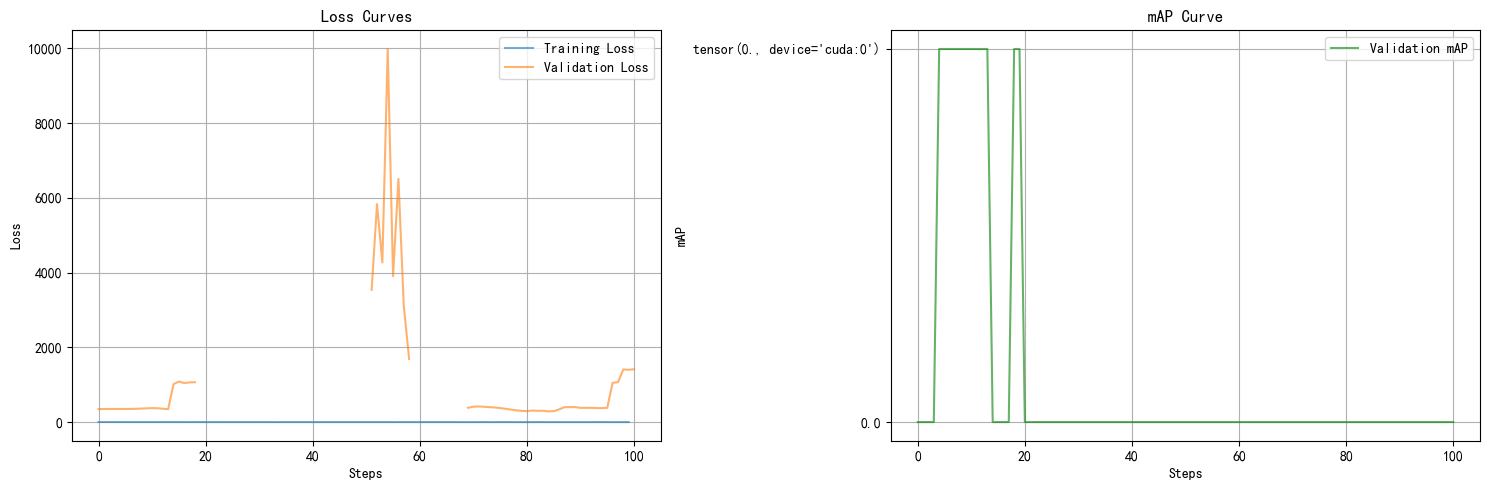


Final Metrics:
Training Loss: 0.0605
Validation Loss: 1413.5731


ValueError: Unknown format code 'f' for object of type 'str'

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from pathlib import Path

class YOLOModule(pl.LightningModule):
    def __init__(self, num_classes=80, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = YoloNetV3()
        self.criterion = YOLOLoss(num_classes=num_classes)
        self.evaluator = YOLOEvaluator(num_classes=num_classes)
        self.learning_rate = learning_rate
        
        # 初始化记录损失的列表
        self.train_losses = []
        self.val_losses = []
        self.val_maps = []
    
    def configure_optimizers(self):
        """配置优化器和学习率调度器"""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.0005  # L2正则化
        )
        
        # 学习率调度器
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1,  # 预热阶段占总步数的比例
            div_factor=25,   # 初始学习率 = max_lr/div_factor
            final_div_factor=1e4  # 最终学习率 = max_lr/(div_factor*final_div_factor)
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"  # 每个step更新一次学习率
            }
        }
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, labels, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        
        # 记录训练损失
        self.train_losses.append({
            'epoch': self.current_epoch,
            'step': self.global_step,
            'loss': loss.item()
        })
        
        # 每100步保存一次损失记录
        if self.global_step % 100 == 0:
            self.save_metrics()
            
        # 记录当前学习率
        current_lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', current_lr, on_step=True, prog_bar=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        mAP = self.evaluator.calculate_map(outputs, labels)  # 这里返回的是float
        
        # 记录验证损失和mAP
        self.val_losses.append({
            'epoch': self.current_epoch,
            'step': self.global_step,
            'loss': loss.item()  # loss是tensor，需要用item()
        })
        self.val_maps.append({
            'epoch': self.current_epoch,
            'step': self.global_step,
            'mAP': mAP  # mAP已经是float，直接使用
        })
        
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_mAP', mAP, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_mAP': mAP}
    
    def save_metrics(self):
        """保存训练指标到文件"""
        metrics_dir = Path('metrics')
        metrics_dir.mkdir(exist_ok=True)
        
        # 保存为CSV格式
        pd.DataFrame(self.train_losses).to_csv(
            metrics_dir / 'train_losses.csv', index=False
        )
        pd.DataFrame(self.val_losses).to_csv(
            metrics_dir / 'val_losses.csv', index=False
        )
        pd.DataFrame(self.val_maps).to_csv(
            metrics_dir / 'val_maps.csv', index=False
        )
        
    def on_train_end(self):
        """训练结束时保存所有指标"""
        self.save_metrics()

def plot_training_metrics(metrics_dir='metrics'):
    """
    可视化训练指标
    Args:
        metrics_dir: 指标文件所在目录
    """
    metrics_dir = Path(metrics_dir)
    
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 绘制损失曲线
    if (metrics_dir / 'train_losses.csv').exists():
        train_losses = pd.read_csv(metrics_dir / 'train_losses.csv')
        ax1.plot(train_losses['step'], train_losses['loss'], 
                label='Training Loss', alpha=0.6)
    
    if (metrics_dir / 'val_losses.csv').exists():
        val_losses = pd.read_csv(metrics_dir / 'val_losses.csv')
        ax1.plot(val_losses['step'], val_losses['loss'], 
                label='Validation Loss', alpha=0.6)
    
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 绘制mAP曲线
    if (metrics_dir / 'val_maps.csv').exists():
        val_maps = pd.read_csv(metrics_dir / 'val_maps.csv')
        ax2.plot(val_maps['step'], val_maps['mAP'], 
                label='Validation mAP', color='g', alpha=0.6)
    
    ax2.set_title('mAP Curve')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('mAP')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印最终指标
    print("\nFinal Metrics:")
    if (metrics_dir / 'train_losses.csv').exists():
        final_train_loss = train_losses['loss'].iloc[-1]
        print(f"Training Loss: {final_train_loss:.4f}")
    
    if (metrics_dir / 'val_losses.csv').exists():
        final_val_loss = val_losses['loss'].iloc[-1]
        print(f"Validation Loss: {final_val_loss:.4f}")
    
    if (metrics_dir / 'val_maps.csv').exists():
        final_map = val_maps['mAP'].iloc[-1]
        print(f"Final mAP: {final_map:.4f}")

# 创建模型和训练器
model = YOLOModule(num_classes=80, learning_rate=1e-3)

logger = pl_loggers.TensorBoardLogger("logs/", name="yolo")

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=100,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            save_top_k=3,
            filename='{epoch}-{val_loss:.2f}'
        )
    ],
    logger=logger,
    log_every_n_steps=1,
    gradient_clip_val=0.5
)

# 训练模型
trainer.fit(model, train_loader, val_loader)

# 绘制训练指标
plot_training_metrics()